In [ ]:
from locale import normalize
import numpy as np
import argparse
import os
import json
import shutil
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def image_points_to_world(image_points, camera_mat, world_mat, scale_mat, invert=True):
    batch_size, n_pts, dim = image_points.shape
    assert(dim == 2)
    d_image = np.ones((batch_size, n_pts, 1))
    return transform_to_world(image_points, d_image, camera_mat, world_mat,
                              scale_mat, invert=invert)

def transform_to_world(pixels, depth, camera_mat, world_mat, scale_mat, invert=True):
    
    assert(pixels.shape[-1] == 2)

    # Invert camera matrices
    if invert:
        camera_mat = np.linalg.inv(camera_mat)
        world_mat = np.linalg.inv(world_mat)
        scale_mat = np.linalg.inv(scale_mat)

    # Transform pixels to homogen coordinates
    pixels = np.transpose(pixels, axes=(0,2,1))
    pixels = np.concatenate([pixels, np.ones_like(pixels)], axis=1)

    # Project pixels into camera space
    pixels[:, :3] = pixels[:, :3] * np.transpose(depth, axes=(0,2,1))

    # Transform pixels to world space
    p_world = scale_mat @ world_mat @ camera_mat @ pixels

    # Transform p_world back to 3D coordinates
    p_world = np.transpose(p_world[:, :3],axes=(0,2,1)) 
    return p_world

def origin_to_world(n_points, camera_mat, world_mat, scale_mat, invert=True):
    ''' Transforms origin (camera location) to world coordinates.

    Args:
        n_points (int): how often the transformed origin is repeated in the
            form (batch_size, n_points, 3)
        camera_mat (tensor): camera matrix
        world_mat (tensor): world matrix
        scale_mat (tensor): scale matrix
        invert (bool): whether to invert the matrices (default: true)
    '''
    batch_size = camera_mat.shape[0]

    # Create origin in homogen coordinates
    p = np.zeros((batch_size, 4, n_points))
    p[:, -1] = 1.

    # Invert matrices
    if invert:
        camera_mat = np.linalg.inv(camera_mat)
        world_mat = np.linalg.inv(world_mat)
        scale_mat = np.linalg.inv(scale_mat)

    # Apply transformation
    p_world = scale_mat @ world_mat @ camera_mat @ p

    # Transform points back to 3D coordinates
    p_world = np.transpose(p_world[:, :3], axes=(0, 2, 1))
    return p_world

def transform_to_camera_space(p_world, camera_mat, world_mat, scale_mat):
    ''' Transforms world points to camera space.
        Args:
        p_world (tensor): world points tensor of size B x N x 3
        camera_mat (tensor): camera matrix
        world_mat (tensor): world matrix
        scale_mat (tensor): scale matrix
    '''
    batch_size, n_p, _ = p_world.shape

    # Transform world points to homogen coordinates
    p_world = np.concatenate([p_world, np.ones((batch_size, n_p, 1))], axis=-1)
    p_world = np.transpose(p_world, axes=(0,2,1))

    # Apply matrices to transform p_world to camera space
    p_cam = camera_mat @ world_mat @ scale_mat @ p_world
    p_temp = world_mat @ scale_mat @ p_world

    
    # normalize
    p_cam = p_cam[:]/p_cam[:,3,:]
    p_cam = p_cam[:]/p_cam[:,2,:]
    p_temp = p_temp[:]/p_temp[:,3,:]
    p_temp = p_temp[:]/p_temp[:,2,:]

    # Transform points back to 3D coordinates
    p_cam = np.transpose(p_cam[:, :3], axes=(0,2,1))
    p_temp  = np.transpose(p_temp[:, :3], axes=(0, 2, 1))

    return p_cam, p_temp
    # return p_cam


In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
x = np.load('/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DTU/scan24/scan/cameras.npz')#['world_mat_2']
S = x['scale_mat_2']
W = x['world_mat_2']
K = x['camera_mat_2']
print(np.linalg.inv(W))
print(W)

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
x = np.load('/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DIY/scan24/scan/cameras.npz')#['world_mat_2']
S = x['scale_mat_2']
W = x['world_mat_2']
K = x['camera_mat_2']
print(np.linalg.inv(W))
print(W)

In [ ]:
# i = 0
# for filename in sorted(os.listdir(directory_cam)):
#     f = os.path.join(directory_cam, filename)
#     if os.path.isfile(f):
#         file = open(f)
#         cam = json.load(file)

#         shutil.copy(directory+'/rgb/1x/'+filename[:-5]+'.png', os.path.join(args.save_dir,'image',str(i).zfill(6)+'.png'))
#         if args.use_mask:
#             shutil.copy(directory+'/rgb/mask/'+filename[:-5]+'.png', os.path.join(args.save_dir,'mask',str(i).zfill(6)+'.png'))

# np.savez(args.save_dir+'/cameras.npz', ** savez_dict)
# for name in ['train','test','val']:
#     if not os.path.isfile(args.save_dir[:-5]+"/"+name+".lst"):
#         with open(args.save_dir[:-5]+"/"+name+".lst", "a") as f:
#             f.write('scan')
#             print(name)
#     else:
#         print(name,'.lst already exists. if you would like to overwrite please delete files manually first')



######### YAML
# import yaml
# with open("./configs/DTU/scan0024.yaml", "r") as stream:
#     try:
#         data = yaml.safe_load(stream)
#     except yaml.YAMLError as exc:
#         print(exc)
# data['dataloading']['path'] = 'data/my_data/'
# data['dataloading']['classes'] = '[{}]'.format(args.capture_name)
# data['dataloading']['n_views'] = i
# scale = 4.
# vis_resolution = '[{0}, {1}]'.format(str(int(shape[0]/scale)),str(int(shape[1]/scale)))
# scheduler_milestones = '[{0}, {1}]'.format(str(data['training']['scheduler_milestones'][0]),str(data['training']['scheduler_milestones'][1]))
# print(i,'total views of size ', vis_resolution)
# data['training']['out_dir'] = './out/DIY/' + args.capture_name + '/'
# data['training']['vis_resolution'] = vis_resolution
# data['training']['scheduler_milestones'] = scheduler_milestones

# with open(args.config_dir+'/'+args.capture_name+'.yaml', 'w') as outfile:
#     yaml.dump(data, outfile, default_flow_style=False)

def project(points, cam):
    points = np.array(points)
    points = points.reshape((-1, 3))
    translated_points = points - cam['position']
    local_points = (np.matmul(cam['orientation'], translated_points.T)).T
    x = local_points[..., 0] / local_points[..., 2]
    y = local_points[..., 1] / local_points[..., 2]
    r2 = x**2 + y**2
    distortion = 1.0 + r2 * (
        cam['radial_distortion'][0] + r2 *
        (cam['radial_distortion'][1] + cam['radial_distortion'][2] * r2))
    x_times_y = x * y
    x = (
        x * distortion + 2.0 * cam['tangential_distortion'][0] * x_times_y +
        cam['tangential_distortion'][1] * (r2 + 2.0 * x**2))
    y = (
        y * distortion + 2.0 * cam['tangential_distortion'][1] * x_times_y +
        cam['tangential_distortion'][0] * (r2 + 2.0 * y**2))
    pixel_x = cam['focal_length'] * x + cam['skew'] * y + cam['principal_point'][0]
    pixel_y = cam['focal_length'] * cam['pixel_aspect_ratio'] * y + cam['principal_point'][1]

    pixels = np.stack([pixel_x, pixel_y], axis=-1)
    return pixels



In [ ]:
def make_model_matrix(directory, use_points=0, use_mask=0, view=1):
    directory_cam = directory+'/camera'
    if use_points:
        coords_og = np.load(directory+'/points.npy',allow_pickle=True)
        scene = json.load(open(directory+'/scene.json'))


        if use_mask:
            import matplotlib.pyplot as plt
            import matplotlib.image as mpimg
            file = open(directory_cam+'/'+str(view+1).zfill(6)+'.json')
            cam = json.load(file)
            coords_filtered = []

            points = coords_og
            pixels = project(points,cam)

            # mask = mpimg.imread(directory+'/rgb/mask/'+str(view+1).zfill(6)+'.png')
            # mask = np.sum(mask,axis=-1)/3.0
            mask = mpimg.imread(directory+'/rgb/mask/'+str(view+1).zfill(6)+'.png')
            mask = np.sum(mask,axis=-1)/3.0
            im = mpimg.imread(directory+'/rgb/1x/'+str(view+1).zfill(6)+'.png')
            shape = mask.shape
            scale = 5.0
            mask = np.array(Image.fromarray((mask*255).astype(np.uint8)).resize((int(shape[1]/scale),int(shape[0]/scale))))
            im = np.array(Image.fromarray((im*255).astype(np.uint8)).resize((int(shape[1]/scale),int(shape[0]/scale))))
            bad = 0
            for i in range(len(pixels)):
                x1 = int(pixels[i,1]/scale)
                x2 = int(pixels[i,0]/scale)
                if True:
                    if x1 < mask.shape[0] and x2 < mask.shape[1] and x1 > -1 and x2 > -1:
                        if mask[x1,x2]>5:
                            mask[x1,x2] = 0
                            im[x1-5:x1,x2-5:x2,:] = [0,255,0]
                            # print('in')
                            coords_filtered.append(coords_og[i])
                        else:
                            mask[x1,x2] = 1
                            im[x1-5:x1,x2-5:x2,:] = [255,0,0]
                            # print('out')
                    else:
                        bad = bad + 1
                        pass
            # plt.imshow(mask)
            plt.imshow(im)
        else:
            coords_filtered = coords_og

        center = np.array(scene['center'])
        coords = np.array(coords_filtered)  
        coords = (coords - center) #/ scene['scale']

        coord_min = np.min(coords, axis=0)
        coord_max = np.max(coords, axis=0)
        pcd_center = (coord_min + coord_max) / 2
        translation = -pcd_center
        diff_center = np.linalg.norm(coords + translation, axis=1)
        max_radius = diff_center.max()
        scale = 1 / max_radius
        M = np.eye(4, dtype=np.float32)
        M[0, 0] = scale
        M[1, 1] = scale
        M[2, 2] = scale
        M[:3, 3] = translation * scale 
        np.set_printoptions(suppress=True, precision = 3)
        # print(M)

        M = np.linalg.inv(M)
        print(M)
        return M
    else:
    ## USING CAMS
        cams = []
        for filename in sorted(os.listdir(directory_cam)):
            f = os.path.join(directory_cam, filename)
            if os.path.isfile(f):
                file = open(f)
                cam = json.load(file)
                cams.append(cam['position'])
        cams = np.array(cams)
        scale = 2/np.max(np.max(cams,axis=0)-np.min(cams,axis=0))
        cams = cams*scale
        translation = np.array(np.array([0,0,1]) - np.mean(cams,axis=0))
        M = np.eye(4, dtype=np.float32)
        M[0, 0] = scale
        M[1, 1] = scale
        M[2, 2] = scale
        M[:3, 3] = translation 
        # print(M)
        # M = np.linalg.inv(M)
        return M

In [ ]:
def make_model_matrix_mult_masks(directory, capture_name, use_points=0, use_mask=0, mask_list=[0]):
    directory_cam = directory+'/camera'
    
    ## USING POINTS.NPY
    if use_points:
        coords_og = np.load(directory+'/points.npy',allow_pickle=True)
        scene = json.load(open(directory+'/scene.json'))

        if use_mask:
            import matplotlib.pyplot as plt
            import matplotlib.image as mpimg
            from PIL import Image

            coords_filtered = coords_og
            coords_thrownout = []
            
            # iterate over files in that directory
            for id in mask_list:
                key = id+1
                f = os.path.join(directory_cam, str(key).zfill(6)+'.json')
                if os.path.isfile(f):
                    file = open(f)
                    cam = json.load(file)

                    # load COLMAP points
                    points = np.array(coords_filtered)
                    pixels = project(points, cam)
                    coords_filtered = []
                    coords_thrownout = []

                    # load rgb
                    im = mpimg.imread(directory+'/rgb/1x/'+str(key).zfill(6)+'.png')
                    shape = im.shape
                    scale = 1.0
                    new_shape = (int(shape[1]/scale),int(shape[0]/scale))
                    im = np.array(Image.fromarray((im*255).astype(np.uint8)).resize(new_shape))
                    imgog = im.copy()
                    
                    # load mask 
                    if capture_name == 'curls':
                        mask = mpimg.imread(directory+'/rgb/mask/'+str(key).zfill(6)+'_mask.png')
                    else:
                        mask = mpimg.imread(directory+'/rgb/mask/'+str(key).zfill(6)+'.png')
                        mask = np.sum(mask,axis=-1)/3.0
                    mask = np.array(Image.fromarray((mask*255).astype(np.uint8)).resize(new_shape))
                    
                    bad = 0
                    for i in range(len(pixels)):
                        x1 = int(pixels[i,1]/scale)
                        x2 = int(pixels[i,0]/scale)
                        dot_size = 20
                        if x1 < new_shape[1] and x2 < new_shape[0] and x1 > -1 and x2 > -1:
                            if mask[x1,x2] > 100 :
                                im[x1-dot_size:x1,x2-dot_size:x2,:] = [0,255,0]
                                # print('in')
                                coords_filtered.append(points[i])
                            else:
                                im[x1-dot_size:x1,x2-dot_size:x2,:] = [255,0,0]

                                coords_thrownout.append(points[i])
                                # print('out')
                        else :
                            bad = bad+1
                            coords_filtered.append(points[i])
                    
                    print('points preserved:', len(coords_filtered), '... throwing out ', len(coords_thrownout), 'points and ', bad, ' points out of range')
            pixels_thrownout = project(coords_thrownout, cam)
            for k in range(len(pixels_thrownout)):
                x2,x1 = pixels_thrownout[k]
                x1 = int(x1)
                x2 = int(x2)
                im[x1-dot_size:x1,x2-dot_size:x2,:] = [255,0,0]

            plt.imshow(mask)
            plt.imshow(im)

            fig=plt.figure()
            fig.add_subplot(1,3,3)
            plt.imshow(imgog)
            fig.add_subplot(1,3,2)
            plt.imshow(im)
            fig.add_subplot(1,3,1)
            plt.imshow(mask)
            plt.show()
        else:
            coords_filtered = coords_og


        center = np.array(scene['center'])
        coords = np.array(coords_filtered)  
        coords = (coords - center) #/ scene['scale']

        coord_min = np.min(coords, axis=0)
        coord_max = np.max(coords, axis=0)
        pcd_center = (coord_min + coord_max) / 2
        translation = -pcd_center
        diff_center = np.linalg.norm(coords + translation, axis=1)
        max_radius = diff_center.max()
        scale = 1 / max_radius
        M = np.eye(4, dtype=np.float32)
        M[0, 0] = scale
        M[1, 1] = scale
        M[2, 2] = scale
        M[:3, 3] = translation * scale 
        np.set_printoptions(suppress=True, precision = 3)
        # print(M)

        M = np.linalg.inv(M)
        print(M)
        return M
    else:
    ## USING CAMS
        cams = []
        for filename in sorted(os.listdir(directory_cam)):
            f = os.path.join(directory_cam, filename)
            if os.path.isfile(f):
                file = open(f)
                cam = json.load(file)
                cams.append(cam['position'])
        cams = np.array(cams)
        scale = 2/np.max(np.max(cams,axis=0)-np.min(cams,axis=0))
        cams = cams*scale
        translation = np.array(np.array([0,0,1]) - np.mean(cams,axis=0))
        M = np.eye(4, dtype=np.float32)
        M[0, 0] = scale
        M[1, 1] = scale
        M[2, 2] = scale
        M[:3, 3] = translation 
        # print(M)
        # M = np.linalg.inv(M)
        return M

## OFFICIAL PREPROCESSING

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import argparse
import os
import json
import shutil
from PIL import Image
from pathlib import Path
import preprocess_cameras

# Arguments
capture_name = 'curls'
root_dir = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs' + '/' + capture_name
save_dir = './data/DIY/'+capture_name+'/scan'
config_dir = './configs/DIY'

directory = str(root_dir)
directory_cam = directory+'/camera'
Path(save_dir+'/image').mkdir(parents=True, exist_ok=True)
Path(save_dir+'/mask').mkdir(parents=True, exist_ok=True)
scene = json.load(open(directory+'/scene.json'))



i = 0
savez_dict = dict()
# iterate over files in that directory
for filename in sorted(os.listdir(directory_cam)):
    f = os.path.join(directory_cam, filename)
    if os.path.isfile(f):
        file = open(f)
        cam = json.load(file)
        

        T = np.eye(4)
        T[:3,3] = -1*np.array(cam['position'])
        R = np.eye(4)
        R[:3,:3] = np.array(cam['orientation'])
        V = np.matmul(R,T)

        K = np.eye(4)
        K[0][0] = cam['focal_length']
        K[0][1] = cam['skew']
        K[0][2] = cam['principal_point'][0]
        K[1][1] = cam['focal_length'] * cam['pixel_aspect_ratio']
        K[1][2] = cam['principal_point'][1]

        savez_dict['world_mat_'  + str(i)] = K @ V
        i = i + 1
        if i == 50:
            break
    
    if i == 50:
        break

## SAVE MATRICES
np.savez(save_dir+"/cameras.npz", **savez_dict)
print(save_dir+"/cameras.npz")
print('done!')

preprocess_cameras.preprocess_cameras(save_dir)

print('for now go manually delete quotation marks in config file for scheduler_milestones and vis_resolution and classes :\'))')
print('now go make ur own config file >:)')

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
import numpy as np

def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

## Projecting using UNISURF CODE

5
bad pts:  10


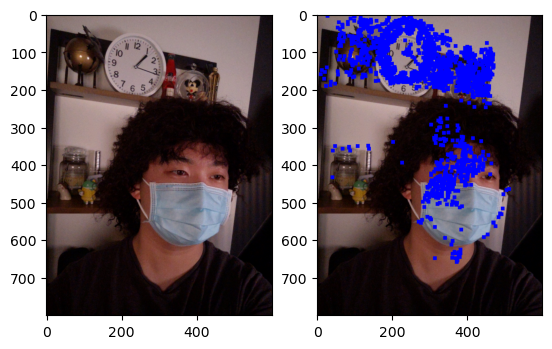

9
bad pts:  1298


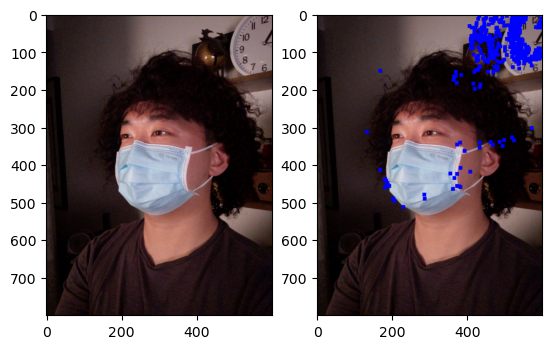

13
bad pts:  475


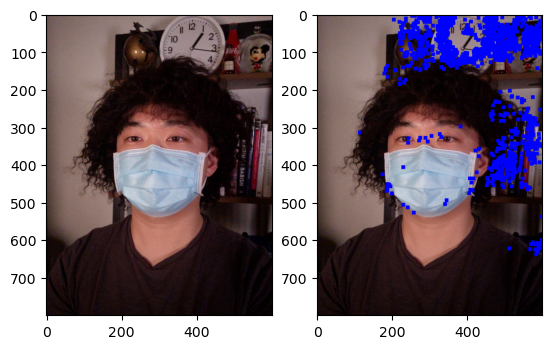

17
bad pts:  141


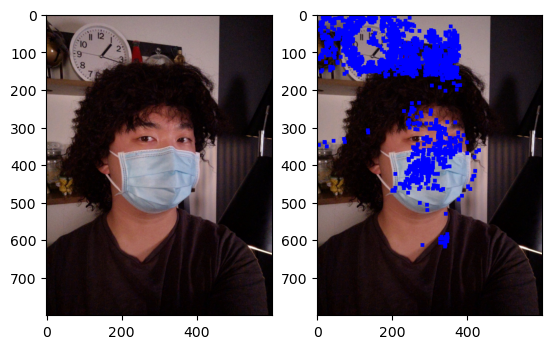

21
bad pts:  142


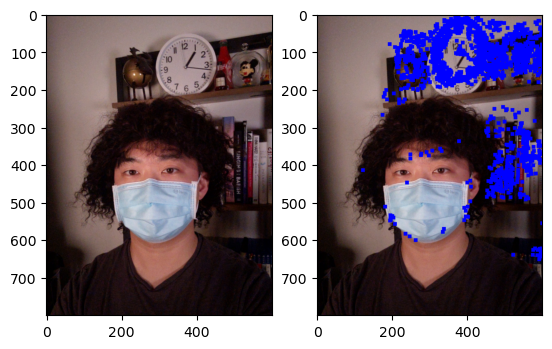

25
bad pts:  1701


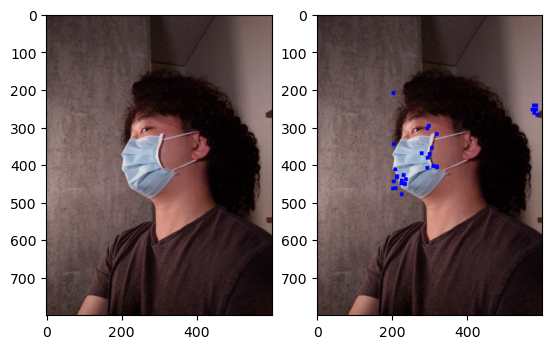

29
bad pts:  1696


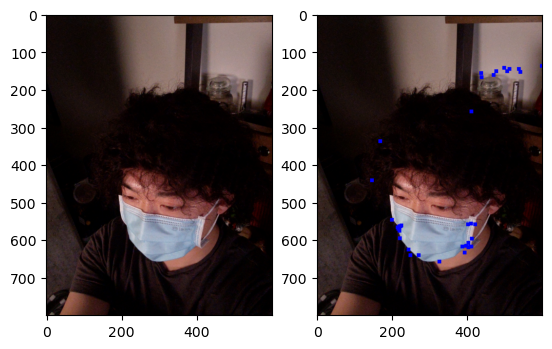

33
bad pts:  900


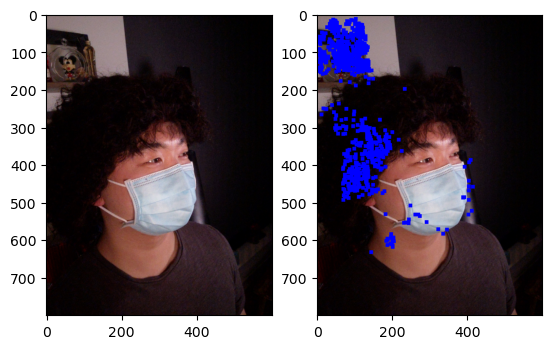

37
bad pts:  17


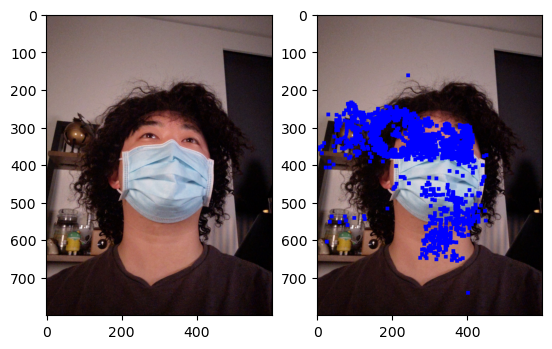

41
bad pts:  252


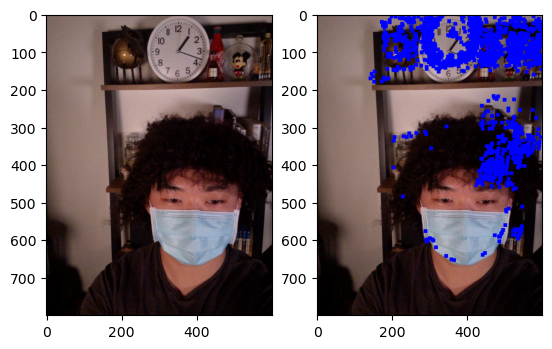

In [142]:
# 3D PTS Projection from IPYNB nerfies projection DTU

# import required module
import os
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import torch


capture_name = 'curls'
# directory = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs/' + capture_name
location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DIY/' + capture_name + '/scan'

# directory = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs/curls/'
# location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DIY/curls/scan'
# location = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/dtu_v3/processed/scan24/'
keys = np.arange(40)[3::4]+2
# keys = [36,44]

camera_dict = np.load(location+'/cameras.npz')  
points = np.load(location+'/points.npy',allow_pickle=True)

# sphere = sample_spherical(1000).T
# sphere = sphere *.66#/2
# # # # points = points + np.array([ 4,-3,17])
# # points = points - np.array([2,0,11])
# # sphere = sphere + np.array([-2.21536032,  2.04177339,  5.31942484])
# points = sphere

K3 = camera_dict['camera_mat_%s' % 3].astype(np.float32)
W3 = camera_dict['world_mat_%s' % 3].astype(np.float32)
S3 = camera_dict['scale_mat_%s' % 3].astype(np.float32)
p = np.concatenate([points.T, np.ones((1, points.shape[0]))], axis=0)
# M = np.linalg.inv(K3@W@S3) @ W
# M = np.linalg.inv(S3)
M = np.eye(4)
p = M @ p
p = p[:3].T

ii = 0
for id in sorted(keys):

    id2 = id #- 2
    # K = camera_dict['camera_mat_%s' % id2].astype(np.float32)
    W = camera_dict['world_mat_%s' % id2].astype(np.float32)
    S = camera_dict['scale_mat_%s' % id2].astype(np.float32)

    K = np.eye(4)
    # S = np.eye(4)
    pixels_cam, _ = transform_to_camera_space(np.expand_dims(p,axis=0), K, W, S)
    
    b = np.squeeze(pixels_cam)[:,:2]#.reshape((240,320,2))

    im2 = location+'/image/'+str(id).zfill(6)+'.png'
    img2 = mpimg.imread(im2)
    shape = img2.shape
    new_shape = np.array(shape[:2])#(120,160)
    temp = new_shape[0]
    new_shape[0] = new_shape[1]
    new_shape[1] = temp
    img2 = np.array(Image.fromarray((img2*255).astype(np.uint8)).resize(new_shape))
    img2og = img2.copy()
    bad = 0
    for i in range(len(b)):
        x1 = int(b[i,1]/(shape[0]/new_shape[1]))
        x2 = int(b[i,0]/(shape[0]/new_shape[1]))
        if x1 < new_shape[1] and x2 < new_shape[0] and x1 > -1 and x2 > -1:
            n = 5
            img2[x1-n:x1+n,x2-n:x2+n,:] = [0,0.,255.]
            # img2[x1,x2,:] = [0,0.,255.]
        else:
            bad = bad + 1
            pass

    print(id)
    print('bad pts: ', bad)
    # plt.imshow(img2)
    fig=plt.figure()
    fig.add_subplot(1,2,ii+2)
    plt.imshow(img2)
    fig.add_subplot(1,2,ii+1)
    plt.imshow(img2og)
    plt.show()


In [141]:
np.load('./data/DIY/toby_100/scan/cameras.npz')['camera_mat_2']

array([[ 0.00373134,  0.        , -1.        ,  0.        ],
       [ 0.        ,  0.00208333, -1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [126]:
points.shape

(2640, 3)

In [107]:
x = points

print(np.min(x,axis=0))
print(np.mean(x,axis=0))
print(np.max(x,axis=0))


[-0.65719991 -0.65974096 -0.65983239]
[-0.00079604  0.00233187  0.0149992 ]
[0.65626012 0.65801833 0.65963629]


In [106]:
x = sphere 

print(np.max(x,axis=0))
print(np.mean(x,axis=0))
print(np.min(x,axis=0))


[0.65626012 0.65801833 0.65963629]
[-0.00079604  0.00233187  0.0149992 ]
[-0.65719991 -0.65974096 -0.65983239]


In [ ]:

p = np.concatenate([points.T, np.ones((1, points.shape[0]))], axis=0)
M = np.linalg.inv(K3@W@S3) @ W
np.linalg.inv(np.linalg.inv(K3@W@S3) @ W)@M@p

In [ ]:
points

In [ ]:
S3

In [ ]:
np.max(b)

In [ ]:
K

In [ ]:
x = K@W@S
np.set_printoptions(suppress=True, precision=2)
np.linalg.inv(x) @ x

In [ ]:
K3

## Projecting matrix nerfies points 

dict_keys([12, 16, 20, 24, 28, 32, 36, 40, 44, 48])
12
bad pts:  1823


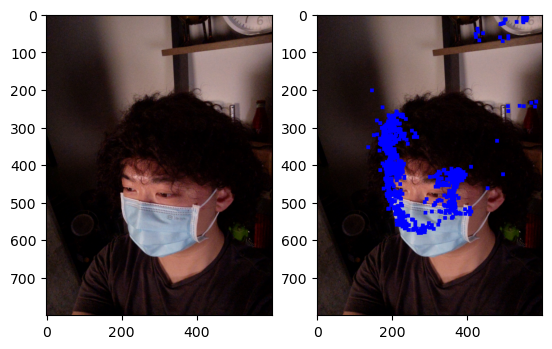

16
bad pts:  383


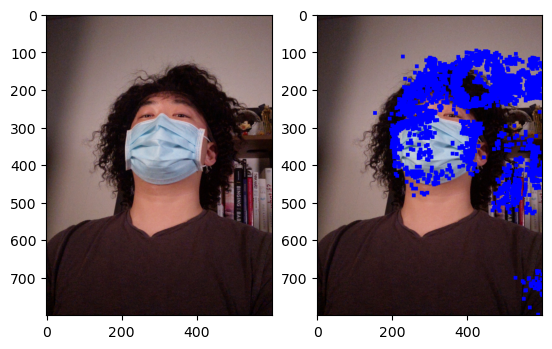

20
bad pts:  604


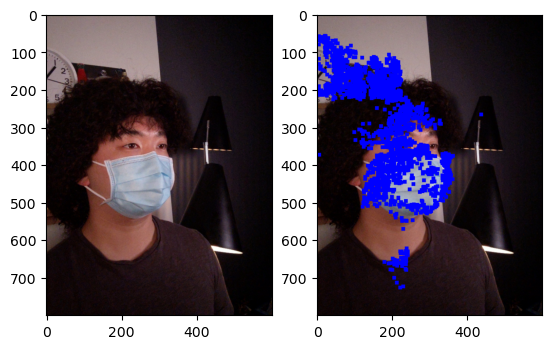

24
bad pts:  1374


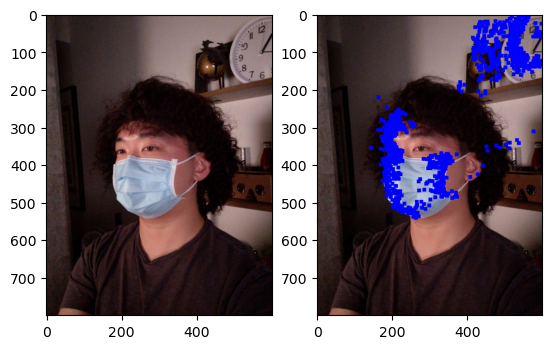

28
bad pts:  1713


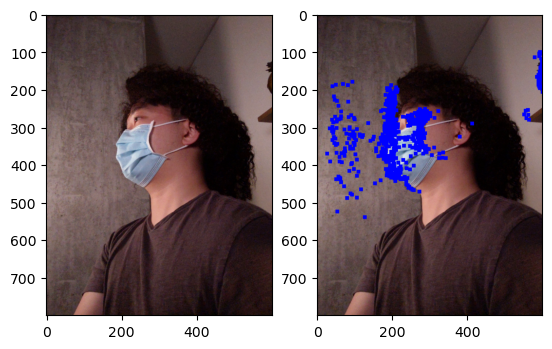

32
bad pts:  1620


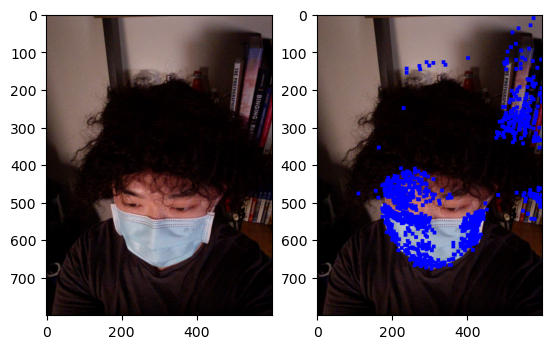

36
bad pts:  1384


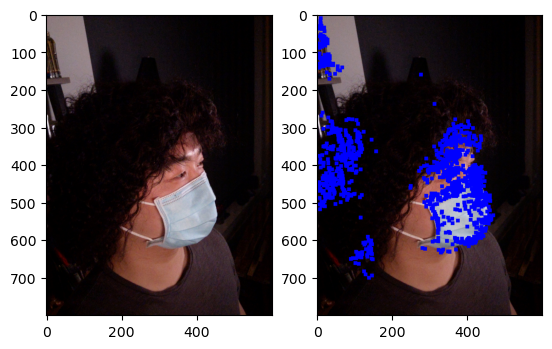

40
bad pts:  103


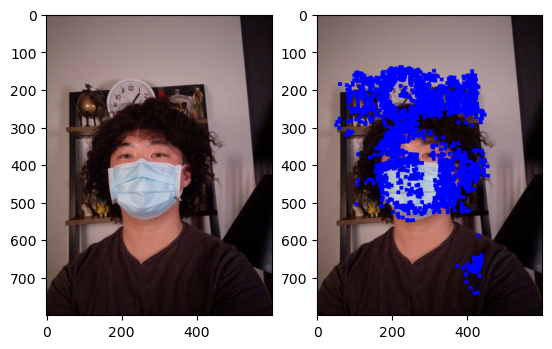

44
bad pts:  513


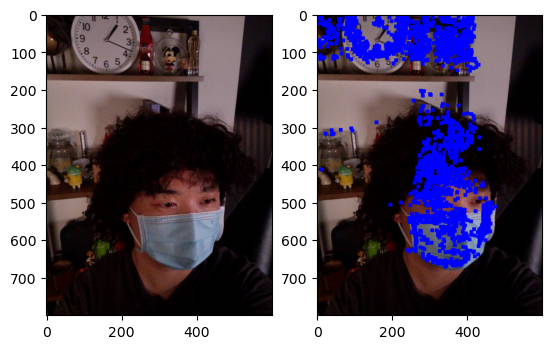

48
bad pts:  107


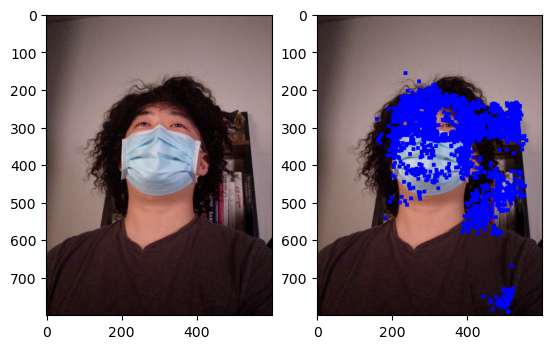

In [144]:
# 3D PTS Projection from IPYNB nerfies projection DTU

# import required module
import os
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import torch

directory = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs/curls/'
location = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/dtu_v3/processed/scan24/'
location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DIY/curls/scan'
keys = np.arange(50)[10::4]+2

camera_dict = np.load(location+'/cameras.npz')  
points = np.load(directory+'points_bg.npy',allow_pickle=True)
y = json.load(open(directory+'scene.json'))
directory_cam = directory+'camera'

# points = np.expand_dims(sample_spherical(1000).T,axis=0)#/4
# points = points *2
# points = points + np.array([ 1,-1,10]) #+ np.array([-2.212,  2.038,  5.318])


blue = {}
i = 0
# iterate over files in that directory
for key in keys:
    ## scan24
    # key = NLRkey + 1    
    file = open(directory_cam+'/'+str(key).zfill(6)+'.json')
    cam = json.load(file)

    points = points.reshape((-1, 3))
    points_homog = np.concatenate((points.T, np.ones_like(points)[:,0].reshape(1,-1)), 0)

    T = np.eye(4)
    T[:3,3] = -1*np.array(cam['position'])
    R = np.eye(4)
    R[:3,:3] = np.array(cam['orientation'])
    V = np.matmul(R,T)

    K = np.eye(4)
    K[0][0] = cam['focal_length']
    K[0][1] = cam['skew']
    K[0][2] = cam['principal_point'][0]
    K[1][1] = cam['focal_length'] * cam['pixel_aspect_ratio']
    K[1][2] = cam['principal_point'][1]

    P = K @ V
    # print(P)
    # print(camera_dict['world_mat_%s' % key],'---')

    pixels =  P @ points_homog
    pixels = pixels.T
    # print(pixels.shape, pixels[..., 2].shape)

    # Get normalized local pixel positions.
    pixels = pixels / np.expand_dims(pixels[..., 3],axis=1)
    pixels = pixels / np.expand_dims(pixels[..., 2],axis=1)
    blue[key] = pixels



ii=0
print(blue.keys())
for id in sorted(blue.keys()):
    b = np.array(blue[id])

    id2 = id - 2
    K = camera_dict['camera_mat_%s' % id2].astype(np.float32)
    W = camera_dict['world_mat_%s' % id2].astype(np.float32)
    S = camera_dict['scale_mat_%s' % id2].astype(np.float32)
    K = np.eye(4) 

    S = np.eye(4)
    p = np.concatenate([points.T, np.ones((1, points.shape[0]))], axis=0)
    M = np.eye(4)
    # M = np.linalg.inv(K@W@S) @ W @ S 
    p = M @ p
    p = p[:3].T
    pixels_cam, p = transform_to_camera_space(np.expand_dims(p,axis=0), K, W, S)
    
    b = np.squeeze(pixels_cam)[:,:2]#.reshape((240,320,2))

    im2 = directory+'rgb/1x/'+str(id).zfill(6)+'.png'
    img2 = mpimg.imread(im2)
    shape = img2.shape
    new_shape = np.array(shape[:2])#(120,160)
    temp = new_shape[0]
    new_shape[0] = new_shape[1]
    new_shape[1] = temp
    img2 = np.array(Image.fromarray((img2*255).astype(np.uint8)).resize(new_shape))
    img2og = img2.copy()
    bad = 0
    for i in range(len(b)):
        x1 = int(b[i,1]/(shape[0]/new_shape[1]))
        x2 = int(b[i,0]/(shape[0]/new_shape[1]))
        if x1 < new_shape[1] and x2 < new_shape[0] and x1 > -1 and x2 > -1:
            n = 5
            img2[x1-n:x1+n,x2-n:x2+n,:] = [0,0.,255.]
            # img2[x1,x2,:] = [0,0.,255.]
        else:
            bad = bad + 1
            pass

    print(id)
    print('bad pts: ', bad)
    # plt.imshow(img2)
    fig=plt.figure()
    fig.add_subplot(1,2,ii+2)
    plt.imshow(img2)
    fig.add_subplot(1,2,ii+1)
    plt.imshow(img2og)
    plt.show()


In [ ]:
K#np.linalg.inv(K)

In [ ]:
np.expand_dims(points,axis=-1).shape

In [ ]:
print(np.min(points,axis=0))
print(np.mean(points,axis=0))
print(np.max(points,axis=0))

In [ ]:
np.linalg.inv(S) @ points#.shape

In [ ]:
points.shape

In [ ]:
(np.linalg.inv(S) @ np.concatenate([points.T, np.ones((1, points.shape[0]))], axis=0))[:3].shape

## Projecting points

In [ ]:
from scipy.spatial.transform import Rotation as Rot

target_view = 30

## SCAN24
location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DIY/toby/scan'
# location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DTU/scan24/scan'

## SCAN55
# location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DIY/scan55/scan'
# location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DTU/scan55/scan'

keys=np.arange(46)[::10]
keys = [19,20,21,22]
    
ii=0
Path(location+'/blue').mkdir(parents=True, exist_ok=True)
camera_dict = np.load(location+'/cameras.npz')  



# K = camera_dict['camera_mat_%s' % target_view].astype(np.float32)
# K = np.eye(4)
# K[0][0] = cam['image_size'][0]/2
# K[0][2] = cam['image_size'][0]/2
# K[1][1] = cam['image_size'][1]/2
# K[1][2] = cam['image_size'][1]/2
# K = np.linalg.inv(K)
    


# W = camera_dict['world_mat_%s' % target_view].astype(np.float32)
# S = camera_dict['scale_mat_%s' % target_view].astype(np.float32)
# pixels_ndc = np.expand_dims(np.load('points/ndc.npy'), axis=0)#[:,::20,:]
# pixels_world = image_points_to_world(pixels_ndc, K, W, S)
# camera_world = origin_to_world(pixels_ndc.shape[1], K, W, S)
# ray_vector = (pixels_world - camera_world).reshape(-1, 3)
# norm = np.tile(np.linalg.norm(ray_vector, ord=2 ,axis=1), (3,1)).T
# ray_vector = np.expand_dims(ray_vector/norm, axis=0)
# ray_vector = ray_vector.reshape(-1, 3)
# dists  = np.expand_dims(np.ones_like(ray_vector[:,0]),axis=1) * 2
# points = camera_world.reshape(-1, 3) + ray_vector * dists
points = np.load(location+'/points.npy')
points = np.expand_dims(points, axis=0)
# scale = 2
# points = np.expand_dims(sample_spherical(1000).T,axis=0)/scale
# points = points + np.array([[1,1,1]])/2
# points[:,:,1] = points[:,:,1] / 4
# points[:,:,2] = points[:,:,2] / 4
# for i in range(1000):
#     if points[0,i,0] > 0 :#and points[0,i,1] > 0 and points[0,i,2] > 0 :
#         points[0,i,:] = np.array([0,0,0])
# points += np.array([  -.1,0.3,0])
# points = np.expand_dims(np.load('points_t.npy'), axis=0)
# points = np.expand_dims(np.load('points_gt0.npy'), axis=0)
# points = points * np.array([-1,-1,1])
# Ry = Rot.from_euler('xyz', [0, 0, 0], degrees=True)
# points = points @ Ry.as_matrix()
# points = np.expand_dims(np.load('/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs/scan24/points.npy'), axis=0)

for id in sorted(keys):
    print('----',id)
    # i = 0
    K = camera_dict['camera_mat_%s' % id].astype(np.float32)
    W = camera_dict['world_mat_%s' % id].astype(np.float32)
    S = camera_dict['scale_mat_%s' % id].astype(np.float32) 
    pixels_cam, p = transform_to_camera_space(points, K, W, S)
    b = np.squeeze(pixels_cam)[:,:2]#.reshape((240,320,2))
    im2 = location+'/image/'+str(id).zfill(6)+'.png'
    img2 = mpimg.imread(im2).copy()
    dim = np.array(img2.shape[:2])
    temp = dim[0]
    dim[0] = dim[1]
    dim[1] = temp
    img2 = np.array(Image.fromarray((img2*255).astype(np.uint8)).resize(dim))
    img2og = img2.copy()
    bad = 0
    n = 2*4
    for i in range(len(b)):
            x1 = int(b[i,1] * (dim[1]/2) + (dim[1]/2)) 
            x2 = int(b[i,0] * (dim[0]/2) + (dim[0]/2))
            if x1 < dim[1] and x2 < dim[0] and x1 > -1 and x2 > -1:
                # color = 255*((points[0,i,0])*(scale/2)+0.5)
                # img2[x1-n:x1+n,x2-n:x2+n,:] = [color,color,color]
                img2[x1-n:x1+n,x2-n:x2+n,:] = [0,0.,255.]
            else:
                bad = bad + 1
                pass
    print(id)
    # print(bad, 'bad points')
    fig=plt.figure()
    fig.add_subplot(1,2,ii+2)
    plt.imshow(img2)
    fig.add_subplot(1,2,ii+1)
    plt.imshow(img2og)
    plt.show()


In [ ]:
11496/6

In [ ]:
K

In [ ]:
x = points
x = np.linalg.inv(K) @ b.T
# x = p
print('min ',np.min(x,axis=1))
print('mean',np.mean(x,axis=1))
print('max ',np.max(x,axis=1))

## Projecting axes

In [ ]:
from scipy.spatial.transform import Rotation as Rot

target_view = 0

## SCAN24
# location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DIY/scan24/scan'
# location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DTU/scan24/scan'

## SCAN55
location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DIY/scan55/scan'
# location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DTU/scan55/scan'

keys=np.arange(46)[::]
keys = [19,24,30]
    
ii=0
Path(location+'/blue').mkdir(parents=True, exist_ok=True)
camera_dict = np.load(location+'/cameras.npz')  
K = camera_dict['camera_mat_%s' % target_view].astype(np.float32)
W = camera_dict['world_mat_%s' % target_view].astype(np.float32)
S = camera_dict['scale_mat_%s' % target_view].astype(np.float32)
pixels_ndc = np.expand_dims(np.load('ndc.npy'), axis=0)#[:,::20,:]
pixels_world = image_points_to_world(pixels_ndc, K, W, S)
camera_world = origin_to_world(pixels_ndc.shape[1], K, W, S)
ray_vector = (pixels_world - camera_world).reshape(-1, 3)
norm = np.tile(np.linalg.norm(ray_vector, ord=2 ,axis=1), (3,1)).T
ray_vector = np.expand_dims(ray_vector/norm, axis=0)
ray_vector = ray_vector.reshape(-1, 3)
dists  = np.expand_dims(np.ones_like(ray_vector[:,0]),axis=1) * 2
points = camera_world.reshape(-1, 3) + ray_vector * dists
points = np.expand_dims(points, axis=0)
scale = 4
points_og = np.expand_dims(sample_spherical(1000).T,axis=0)/scale

for id in sorted(keys):
    points = points_og.copy()
    i = 0
    K = camera_dict['camera_mat_%s' % id].astype(np.float32)
    W = camera_dict['world_mat_%s' % id].astype(np.float32)
    S = camera_dict['scale_mat_%s' % id].astype(np.float32)
    im2 = location+'/image/'+str(id).zfill(6)+'.png'
    img2 = mpimg.imread(im2).copy()
    img2 = np.array(Image.fromarray((img2*255).astype(np.uint8)).resize(dim))
    img2og = img2.copy()
    for j in [0,1,2]:
        points = points_og.copy()
        # print(j)
        for k in [0,1,2]:
            if not (j == k):
                # print('-',k)
                points[:,:,k] = points[:,:,k] / 10
        points = np.expand_dims(points[0,points[0,:,j]>0,:],axis=0)
        pixels_cam = transform_to_camera_space(points, K, W, S)
        dim = [1600,1200]
        b = np.squeeze(pixels_cam)[:,:2]#.reshape((240,320,2))
        bad = 0
        n = 2*4
        for i in range(len(b)):
                x1 = int(b[i,1] * (dim[1]/2) + (dim[1]/2)) 
                x2 = int(b[i,0] * (dim[0]/2) + (dim[0]/2))
                if x1 < dim[1] and x2 < dim[0] and x1 > -1 and x2 > -1:
                    colorarr = [0.,0.,0.]
                    colorarr[j] = 255*((points[0,i,j])*(scale/2)+0.5)
                    img2[x1-n:x1+n,x2-n:x2+n,:] = colorarr
                    # img2[x1-n:x1+n,x2-n:x2+n,:] = [0,0.,255.]
                else:
                    bad = bad + 1
                    pass
    print(id)
    # print(bad, 'bad points')
    fig=plt.figure()
    fig.add_subplot(1,2,ii+2)
    plt.imshow(img2)
    fig.add_subplot(1,2,ii+1)
    plt.imshow(img2og)
    plt.show()


## UNISURF to NLR 

In [ ]:
from scipy.spatial.transform import Rotation as Rot

target_view = 0

## SCAN24
# location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DIY/scan24/scan'
# location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DTU/scan24/scan'

## SCAN55
location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DIY/scan55/scan'
location = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DTU/scan55/scan'

Gt = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/dtu_v3/processed/scan55-og'

land_dir = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/nlr/scan55-uni'

keys=np.arange(49)[::]

M = camera_dict['scale_mat_%s' % id].astype(np.float32) 
Mdict = np.array({'model_matrix': M})
npy_name = os.path.join(land_dir,'model_matrix.npy')
np.save(npy_name, Mdict, allow_pickle=True)

Path(location+'/blue').mkdir(parents=True, exist_ok=True)
camera_dict = np.load(location+'/cameras.npz')  
for id in sorted(keys):
    
    P = np.load(Gt+'/'+str(id).zfill(6)+'_rgb_meta.npy',allow_pickle=True).item()['projection']
    V = camera_dict['world_mat_inv_%s' % id].astype(np.float32)
    meta = np.array({
        'name': str(keys).zfill(6),
        'view': V,
        'projection': P,
        'resolution': np.array([1600, 1200])
        })

    file.close()
    npy_name = os.path.join(land_dir,str(id).zfill(6)+'_rgb_meta.npy')
    np.save(npy_name, meta, allow_pickle=True)


## MetaNLR adapted PREPROCESSING

In [ ]:
import numpy as np
import argparse
import os
import json
import shutil
from PIL import Image
from pathlib import Path

# Arguments
capture_name = 'scan55'
root_dir = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs' + '/' + capture_name
save_dir = './data/DIY/'+capture_name+'/scan'
config_dir = './configs/DIY'
use_points = 1 
use_mask = 1
view = 0  
max_masks_used = 1
mask_list = [0]


directory = str(root_dir)
directory_cam = directory+'/camera'
Path(save_dir+'/image').mkdir(parents=True, exist_ok=True)
Path(save_dir+'/mask').mkdir(parents=True, exist_ok=True)
scene = json.load(open(directory+'/scene.json'))

GTcamera_file = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DTU/'+capture_name+'/scan/cameras.npz'
GTcamera_dict = np.load(GTcamera_file)  

## MODEL_MATRIX
M = make_model_matrix(directory, use_points=use_points, use_mask=use_mask, view=view)
# M = make_model_matrix_mult_masks(directory, capture_name=capture_name, use_points=use_points, use_mask=use_mask, mask_list=mask_list)

i = 0
savez_dict = dict()
# iterate over files in that directory
for filename in sorted(os.listdir(directory_cam)):
    f = os.path.join(directory_cam, filename)
    if os.path.isfile(f):
        file = open(f)
        cam = json.load(file)
        

        ## VIEW MATRIX
        T = np.eye(4)
        T[:3,3] = (-1*np.array(cam['position']))
        T[:3,3] = T[:3,3]#*np.array([[1,-1,-1]])
        R = np.eye(4)
        R[:3,:3] = np.array(cam['orientation']) 
        R[:3,:3] = R[:3,:3]#*np.array([[1,-1,-1]])
        V = np.matmul(R,T)#*np.array([[1,-1,-1,1]]).T


        ## PROJECTION MATRIX
        P = np.zeros((4,4))
        fx = cam['focal_length']
        fy = cam['focal_length'] * cam['pixel_aspect_ratio']
        cx = cam['principal_point'][0]
        cy = cam['principal_point'][1]
        w  = cam['image_size'][0]
        h  = cam['image_size'][1]
        zn = scene['near']*scene['scale']
        zf = scene['far']/scene['scale']

        P[0][0] = 2*fx/w 
        P[0][2] = 1 - 2*cx/w 

        P[1][1] = 2*fy/h
        P[1][2] = 2*cy/h - 1

        P[2][2] = (zn+zf)/(zn-zf)
        P[2][3] = (zn*zf)/(zn-zf)*2

        P[3][2] = -1.
        
        savez_dict['scale_mat_'  + str(i)] = M
        savez_dict['world_mat_'  + str(i)] = V
        savez_dict['camera_mat_' + str(i)] = P
        i = i + 1
        if i == 50:
            break
    
    if i == 50:
        break

np.savez(save_dir+"/cameras.npz", **savez_dict)
print(save_dir+"/cameras.npz")
print('done!')

print('for now go manually delete quotation marks in config file for scheduler_milestones and vis_resolution and classes :\'))')
# print('now go make ur own config file >:)')


## Preprocessing

In [ ]:
from contextlib import suppress
import numpy as np
import argparse
import os
import json
import shutil
from PIL import Image
from pathlib import Path

# Arguments
capture_name = 'scan24'
root_dir = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs' + '/' + capture_name
save_dir = './data/DIY/'+capture_name+'/scan'
config_dir = './configs/DIY'
use_points = 1 
use_mask = 1  
view = 1  



directory = str(root_dir)
directory_cam = directory+'/camera'
Path(save_dir+'/image').mkdir(parents=True, exist_ok=True)
Path(save_dir+'/mask').mkdir(parents=True, exist_ok=True)

GT = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DTU/scan24/scan/'
GTcamera_file = os.path.join(GT, 'cameras.npz')
GTcamera_dict = np.load(GTcamera_file)  

## MODEL_MATRIX
M = make_model_matrix(directory, use_points=use_points, use_mask=use_mask, view=view)

## PROJECTION MATRIX
K = np.eye(4)
h, w, c = mpimg.imread(directory+'/rgb/1x/'+str(view+1).zfill(6)+'.png').shape

K[0][0] = int(w/2.)
K[0][2] = int(w/2.)
K[1][1] = int(h/2.)
K[1][2] = int(h/2.)
print(K)
K = np.linalg.inv(K)

i = 0
savez_dict = dict()
# iterate over files in that directory
for filename in sorted(os.listdir(directory_cam)):
    f = os.path.join(directory_cam, filename)
    if os.path.isfile(f):
        file = open(f)
        cam = json.load(file)
        

        
        ## VIEW MATRIX
        Rt = np.eye(4)
        Rt[:3,3] = np.array(cam['position'])
        Rt[:3,:3] = np.array(cam['orientation'])


        ## GT scan24
        id = int(filename[:-5])-1
        # K = GTcamera_dict['camera_mat_%s' % id].astype(np.float32)
        # Rt = GTcamera_dict['world_mat_%s' % id].astype(np.float32)
        # M = GTcamera_dict['scale_mat_%s' % id].astype(np.float32)
        
        # print(filename, i)
        savez_dict['world_mat_' + str(i)] = Rt
        savez_dict['scale_mat_' + str(i)] = M
        savez_dict['camera_mat_' + str(i)] = K
        # savez_dict['camera_mat_inv_' + str(i)] = np.linalg.inv(K)
        i = i + 1
        if i == 50:
            break
    
    if i == 50:
        break

np.savez(save_dir+"/cameras.npz", **savez_dict)
print(save_dir+"/cameras.npz")
print('done!')

print('for now go manually delete quotation marks in config file for scheduler_milestones and vis_resolution and classes :\'))')
# print('now go make ur own config file >:)')


## Nerfies projection

In [ ]:
# 3D PTS Projection from IPYNB nerfies projection DTU

# import required module
import os
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import torch

directory = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs/scan24/'
# location = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/dtu_v3/processed/scan24/'

points = np.load(directory+'points.npy',allow_pickle=True)
y = json.load(open(directory+'scene.json'))
directory_cam = directory+'camera'

# points = np.expand_dims(sample_spherical(1000).T,axis=0)#/4
# points = points /4
# points = points + np.array([-2.212,  2.038,  5.318])


blue = {}
i = 0
# iterate over files in that directory
for key in [19,23,30,31]:
    ## scan24
    # key = NLRkey + 1    
    file = open(directory_cam+'/'+str(key).zfill(6)+'.json')
    cam = json.load(file)

    points = points.reshape((-1, 3))

    points_homog = np.concatenate((points.T, np.ones_like(points)[:,0].reshape(1,-1)), 0)
    # translated_points = points - cam['position']
    # local_points = (np.matmul(cam['orientation'], translated_points.T)).T


    T = np.eye(4)
    T[:3,3] = -1*np.array(cam['position'])
    R = np.eye(4)
    R[:3,:3] = np.array(cam['orientation'])
    V = np.matmul(R,T)#*np.array([[1,-1,-1,1]]).T

    local_points = V  @ points_homog
    local_points = local_points.T

    # Get normalized local pixel positions.
    x = local_points[..., 0] / local_points[..., 2]
    y = local_points[..., 1] / local_points[..., 2]

    # Map the distorted ray to the image plane and return the depth.
    pixel_x = cam['focal_length'] * x + cam['skew'] * y + cam['principal_point'][0]
    pixel_y = cam['focal_length'] * cam['pixel_aspect_ratio'] * y + cam['principal_point'][1]

    pixels = np.stack([pixel_x, pixel_y], axis=-1)
    blue[key] = pixels


ii=0
print(blue.keys())
for id in sorted(blue.keys()):
    b = np.array(blue[id])

    im2 = directory+'/rgb/1x/'+str(id).zfill(6)+'.png'
    img2 = mpimg.imread(im2)
    shape = img2.shape
    new_shape = (160,120)
    img2 = np.array(Image.fromarray((img2*255).astype(np.uint8)).resize(new_shape))
    img2og = img2.copy()
    bad = 0
    for i in range(len(b)):
        x1 = int(b[i,1]/(shape[0]/new_shape[1]))
        x2 = int(b[i,0]/(shape[0]/new_shape[1]))
        if x1 < 120 and x2 < 160 and x1 > -1 and x2 > -1:
            n = 2
            # img2[x1-n:x1+n,x2-n:x2+n,:] = [0,0.,255.]
            img2[x1,x2,:] = [0,0.,255.]
        else:
            bad = bad + 1
            pass

    print(id)
    print('bad pts: ', bad)
    # plt.imshow(img2)
    fig=plt.figure()
    fig.add_subplot(1,2,ii+2)
    plt.imshow(img2)
    fig.add_subplot(1,2,ii+1)
    plt.imshow(img2og)
    plt.show()


In [ ]:
print(fx,cam['image_size'][0],2*fx/cam['image_size'][0])

In [ ]:
# # 3D PTS Projection from IPYNB nerfies projection DTU

# import required module
import os
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import torch

directory = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs/scan24/'
location = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/dtu_v3/processed/scan24/'

points = np.load(directory+'points.npy',allow_pickle=True)
y = json.load(open(directory+'scene.json'))
directory = directory+'camera'

# points = np.expand_dims(sample_spherical(1000).T,axis=0)#/4
# points = points /4
# points = points + np.array([-2.212,  2.038,  5.318])


blue = {}
i = 0
# iterate over files in that directory
for NLRkey in [0,2,4,6,8,10]:
    ## scan24
    key = NLRkey + 1    
    file = open(directory+'/'+str(key).zfill(6)+'.json')
    cam = json.load(file)

    points = points.reshape((-1, 3))

    points_homog = np.concatenate((points.T, np.ones_like(points)[:,0].reshape(1,-1)), 0)
    # translated_points = points - cam['position']
    # local_points = (np.matmul(cam['orientation'], translated_points.T)).T


    T = np.eye(4)
    T[:3,3] = -1*np.array(cam['position'])
    R = np.eye(4)
    R[:3,:3] = np.array(cam['orientation'])
    V = np.matmul(R,T)#*np.array([[1,-1,-1,1]]).T

    local_points = V  @ points_homog
    local_points = local_points.T

    # Get normalized local pixel positions.
    x = local_points[..., 0] / local_points[..., 2]
    y = local_points[..., 1] / local_points[..., 2]

    # Map the distorted ray to the image plane and return the depth.
    pixel_x = cam['focal_length'] * x + cam['skew'] * y + cam['principal_point'][0]
    pixel_y = cam['focal_length'] * cam['pixel_aspect_ratio'] * y + cam['principal_point'][1]

    pixels = np.stack([pixel_x, pixel_y], axis=-1)
    blue[NLRkey] = pixels


ii=0
print(blue.keys())
for id in sorted(blue.keys()):
    b = np.array(blue[id])

    im2 = location+'/'+str(id).zfill(6)+'_rgb.png'
    img2 = mpimg.imread(im2)
    shape = img2.shape
    new_shape = (160,120)
    img2 = np.array(Image.fromarray((img2*255).astype(np.uint8)).resize(new_shape))
    img2og = img2.copy()
    bad = 0
    for i in range(len(b)):
        x1 = int(b[i,1]/(shape[0]/new_shape[1]))
        x2 = int(b[i,0]/(shape[0]/new_shape[1]))
        if x1 < 120 and x2 < 160 and x1 > -1 and x2 > -1:
            n = 2
            # img2[x1-n:x1+n,x2-n:x2+n,:] = [0,0.,255.]
            img2[x1,x2,:] = [0,0.,255.]
        else:
            bad = bad + 1
            pass

    print(id)
    print('bad pts: ', bad)
    # plt.imshow(img2)
    fig=plt.figure()
    fig.add_subplot(1,2,ii+2)
    plt.imshow(img2)
    fig.add_subplot(1,2,ii+1)
    plt.imshow(img2og)
    plt.show()

## preprocessing that works for just sphere //2

In [ ]:
# from contextlib import suppress
# import numpy as np
# import argparse
# import os
# import json
# import shutil
# from PIL import Image
# from pathlib import Path

# # Arguments
# capture_name = 'scan24'
# root_dir = '/ubc/cs/research/kmyi/svsamban/research/metanlrpp/my_data/my_dtu/colmap_outputs' + '/' + capture_name
# save_dir = './data/DIY/'+capture_name+'/scan'
# config_dir = './configs/DIY'
# use_points = 1 
# use_mask = 1  
# view = 31  


# directory = str(root_dir)
# directory_cam = directory+'/camera'
# Path(save_dir+'/image').mkdir(parents=True, exist_ok=True)
# Path(save_dir+'/mask').mkdir(parents=True, exist_ok=True)

# GTcamera_file = '/ubc/cs/research/kmyi/svsamban/research/unisurf/data/DTU/scan24/scan/cameras.npz'
# GTcamera_dict = np.load(GTcamera_file)  

# ## MODEL_MATRIX
# M = make_model_matrix(directory, use_points=use_points, use_mask=use_mask, view=view)

# i = 0
# savez_dict = dict()
# # iterate over files in that directory
# for filename in sorted(os.listdir(directory_cam)):
#     f = os.path.join(directory_cam, filename)
#     if os.path.isfile(f):
#         file = open(f)
#         cam = json.load(file)
        

#         ## VIEW MATRIX
#         T = np.eye(4)
#         T[:3,3] = (-1*np.array(cam['position']))
#         T[:3,3] = T[:3,3]#*np.array([[1,-1,-1]])
#         R = np.eye(4)
#         R[:3,:3] = np.array(cam['orientation']) 
#         R[:3,:3] = R[:3,:3]#*np.array([[1,-1,-1]])
#         V = np.matmul(R,T)#*np.array([[1,-1,-1,1]]).T


#         ## PROJECTION MATRIX
#         P = np.zeros((4,4))
#         fx = cam['focal_length']
#         fy = cam['focal_length'] * cam['pixel_aspect_ratio']
#         cx = cam['principal_point'][0]
#         cy = cam['principal_point'][1]
#         w  = cam['image_size'][0]
#         h  = cam['image_size'][1]
#         zn = scene['near']*scene['scale']
#         zf = scene['far']/scene['scale']

#         P[0][0] = 2*fx/w 
#         P[0][2] = 1 - 2*cx/w 

#         P[1][1] = 2*fy/h
#         P[1][2] = 2*cy/h - 1

#         P[2][2] = (zn+zf)/(zn-zf)
#         P[2][3] = (zn*zf)/(zn-zf)*2

#         P[3][2] = -1.

#         ## GT scan24
#         # id = int(filename[:-5])-1
#         # M = GTcamera_dict['scale_mat_%s' % id].astype(np.float32)
#         # V = GTcamera_dict['world_mat_%s' % id].astype(np.float32)
#         # P = GTcamera_dict['camera_mat_%s' % id].astype(np.float32)
        
#         ## INVERSE? 
#         # M = np.linalg.inv(M)
#         # V = np.linalg.inv(V)
#         # P = np.linalg.inv(P)
        
#         # print(filename, i)
#         savez_dict['scale_mat_'  + str(i)] = M
#         savez_dict['world_mat_'  + str(i)] = V
#         savez_dict['camera_mat_' + str(i)] = P
#         # savez_dict['camera_mat_inv_' + str(i)] = np.linalg.inv(K)
#         i = i + 1
#         if i == 50:
#             break
    
#     if i == 50:
#         break

# np.savez(save_dir+"/cameras.npz", **savez_dict)
# print(save_dir+"/cameras.npz")
# print('done!')

# print('for now go manually delete quotation marks in config file for scheduler_milestones and vis_resolution and classes :\'))')
# # print('now go make ur own config file >:)')
